# Final Report - Different Heart Rate Between Females and Males

## Introduction
Heart disease is a leading cause of death worldwide (Roth., et al, 2020). It is a series of conditions including irregular heartbeats, vascular disease (e.g. coronary artery disease), etc (Tsao., et al, 2022). In addition, the effects of heart disease may differ between sexes (Di Fusco., et al, 2014). In this study, we explore whether there is a difference in heart rate between males and females.

#### Inferential Question
Does the average maximum heart rate achieved differ between males and females? Is maximum heart rate dependent on sex?

#### Dataset
Our dataset comes from a database studying heart disease with 76 attributes, filtered down to 14. The dataset was compiled in 1988 as four regional subsets: Cleveland (CL), Hungary (HG), Switzerland (SW), and VA Long Beach (VA). We will only be looking at two variables: sex (male, female) and maximum heart rate achieved.


# Methods

## Preliminary Analysis
First, we will import our dataset directly from the <a href="https://archive.ics.uci.edu/ml/datasets/Heart+Disease">UCI Machine Learning Repository</a>. Then we will tidy it, and select our variables. We also renamed the sex values for better readability.

In [1]:
library(infer)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
# here we import each regional subset
cl <- read.csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", header = FALSE) %>%
    mutate(region = "CL") # cleveland
hg <- read.csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", header = FALSE) %>%
    mutate(region = "HG") # hungary
va <- read.csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data", header = FALSE) %>%
    mutate(region = "VA") # va long beach
sw <- read.csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data", header = FALSE) %>%
    mutate(region = "SW") # switzerland

# here we merge all four subsets together, and select the needed variables, and rename them for readibility
data <- rbind(cl, hg, va, sw) %>%
    select(V2, V8) %>%
    rename(sex = V2, max_heart_rate = V8) %>%
    mutate(max_heart_rate = as.numeric(max_heart_rate)) %>%
    filter(!is.na(max_heart_rate))

# we also changed max_heart_rate to be reported in double rather than as char, and filtered out the N/A values

# here we renamed the sex categories from integers to readable text

data$sex[data$sex == 1] <- "Male"
data$sex[data$sex == 0] <- "Female"

# viewing a snippet of our data
head(data)

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


,sex,max_heart_rate
,<chr>,<dbl>
1,Male,150
2,Male,108
3,Male,129
4,Male,187
5,Female,172
6,Male,178


*table 1*

Now, we visualize our data. We chose to start by two histograms comparing the maximum heart rate across the sexes.

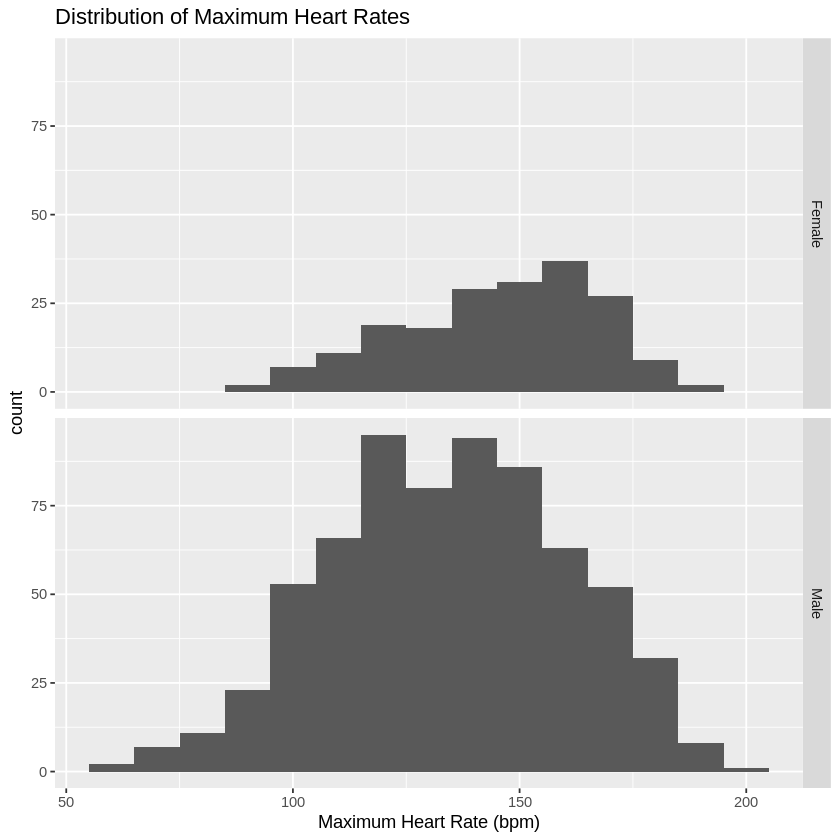

In [3]:
max_heart_rate_hist <- data %>%
                        ggplot() + 
                        geom_histogram(aes(x = max_heart_rate), binwidth = 10) +
                        ggtitle("Distribution of Maximum Heart Rates") +
                        facet_grid(sex ~ .) +
                        xlab("Maximum Heart Rate (bpm)")
max_heart_rate_hist

*plot 1*

We also chose to compare the distribution of the sexes through Boxplots.

ERROR: Error in eval(expr, envir, enclos): object 'p_estim' not found


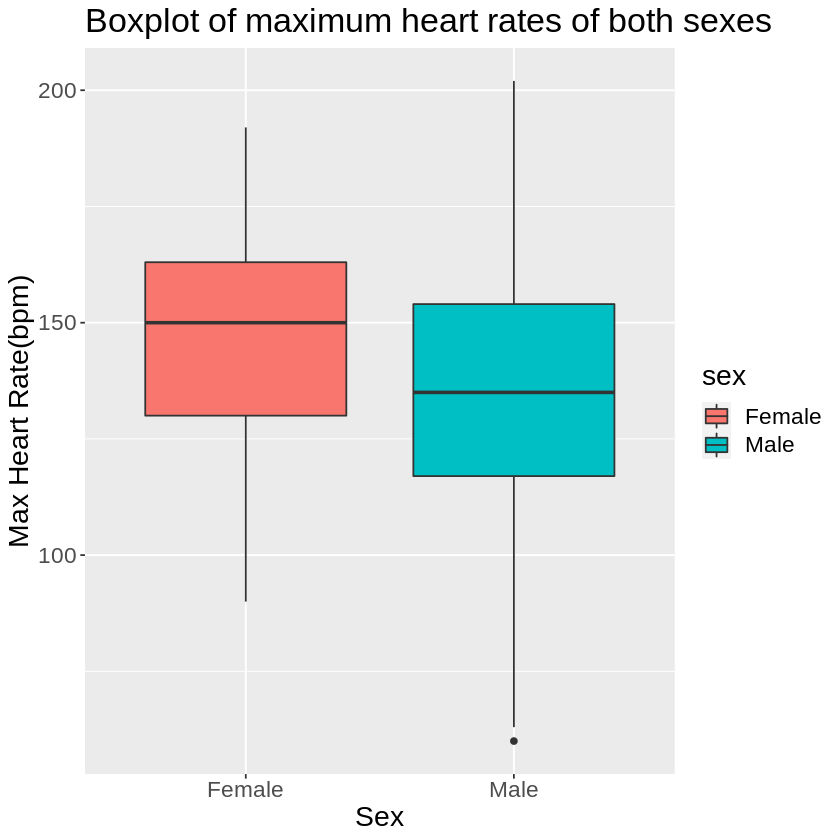

In [4]:
max_heart_rate_boxplots <-
    data %>% 
    ggplot() +
    geom_boxplot(aes(sex, max_heart_rate, fill = sex)) +
    theme(text = element_text(size = 17)) +
    ggtitle("Boxplot of maximum heart rates of both sexes") + 
    xlab("Sex") + 
    ylab("Max Heart Rate(bpm)") 
   

max_heart_rate_boxplots
p_estim

*plot 2*

We can see from the peak of the histograms and the black line going through the boxplots that females seem to be able to achieve higher maximum heart rates than males. But we should keep in mind that we only have a sample and not all existing individuals$-$this is not enough for us to form any conclusions.

Now, let's find our sample statistic, a point estimate for our population parameter. We will do this by finding the average maximum heart rate of each sex in our sample and then calculating the difference between them.

In [5]:
# here we find the sample mean of max heart rate among each sex

means <- data %>%
    group_by(sex) %>%
    summarise(mean = mean(max_heart_rate))

# here we find the sample difference in means between the two sexes
p_estim <- means %>%
    pivot_wider(names_from = "sex", values_from = "mean") %>%
    mutate(Diff = Female - Male)

p_estim

Female,Male,Diff
<dbl>,<dbl>,<dbl>
146.2448,135.0639,11.1809


*table 2*

Our sample difference in means of max heart rate across the sexes is 11.18 bpm. We can visualize this in a density graph with the mean of each sex highlighted.

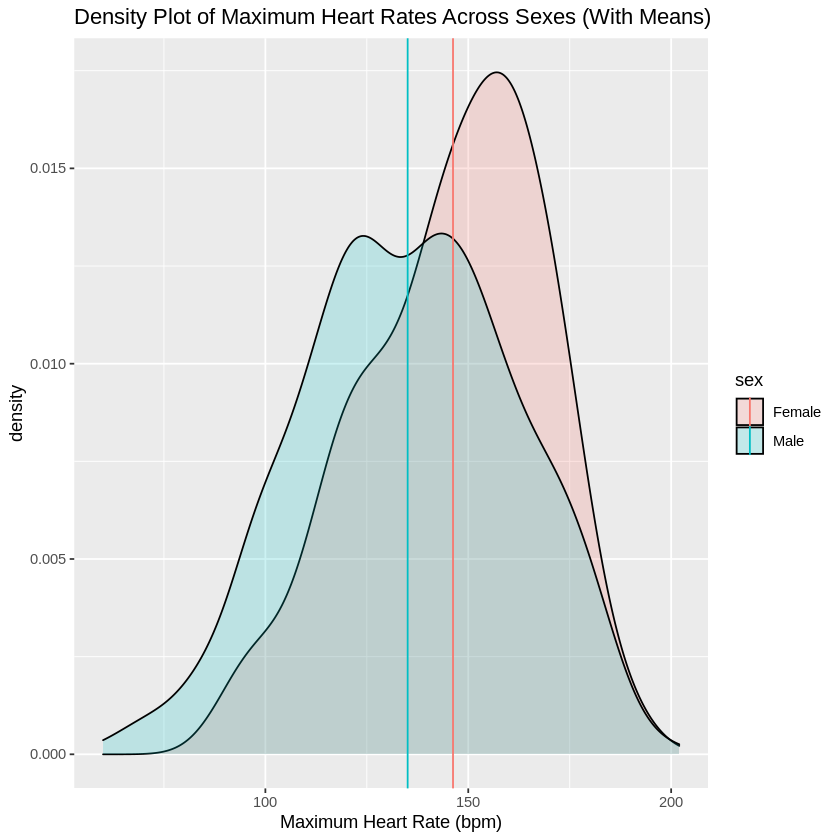

In [6]:
max_heart_rate_density_plot <- data %>%
    ggplot(aes(x = max_heart_rate, fill = sex)) + 
    geom_density(alpha = 0.2) +
    labs(x = "Maximum Heart Rate (bpm)",
         title = "Density Plot of Maximum Heart Rates Across Sexes (With Means)") +
    geom_vline(data = means, aes(xintercept = mean, color = sex), size = 0.5)

max_heart_rate_density_plot

*plot 3*

### Using Asymptotics to Perform Hypothesis Testing: `two-sample t-test`


Again, our parameter estimate is only based on our one sample, and will never fully represent the population. Therefore, we cannot just base our conclusions for the population based on our parameter estimate. To produce more accurate approximations, it is practical to use a theory-based hypothesis test. We will be performing the hypothesis test at a **5% significance level**.

The `t-test` is a more appropriate test to use because the population standard deviation is unknown. The difference between the normal and the t-distribution is that the latter has thicker tails, which indicates higher chances of getting extreme values. However, since our degree of freedom is substantial, the t-distribution would be much closer to the normal distribution, and the difference of using the t-distribution instead of the normal distribution diminishes.

To answer the question, we will test the following hypotheses:
$$H_0: \mu_{\text{Female}} - \mu_{\text{Male}} = 0$$ $$H_1: \mu_{\text{Female}} - \mu_{\text{Male}} \neq 0$$
using the following test statistic:
$$
T = \frac{\bar{x}_{\text{Female}} - \bar{x}_{\text{Male}}}{\sqrt{\frac{s^2_{\text{Female}}}{n_1}+\frac{s^2_{\text{Male}}}{n_2}}}
$$
where $\bar{x}_{\text{Female}}$ and $\bar{x}_{\text{Male}}$ are the sample means of maximum heart rates for Females and Males, respectively; $s^2_{\text{Female}}$ and $s^2_{\text{Male}}$ are the sample variances for Females and Males, respectively; and $n_1$ and $n_2$ are the sample size for Females and Males, respectively. 


In [7]:
set.seed(251)
avg_f_mhr <- p_estim$Female # sample mean of female max heart rate
avg_m_mhr <- p_estim$Male   # sample mean of male max heart rate 

var_data <- data %>%
    group_by(sex) %>%
    summarise(var = sd(max_heart_rate)^2)   # calculate the sample variances

var_f_mhr <- var_data$var[1]  # sample variance of female max heart rate
var_m_mhr <- var_data$var[2]  # sample variance of male max heart rate

num_data <- data %>%
    group_by(sex) %>%
    summarise(count = n())   # calculate num of observations for each sex

n_f <- num_data$count[1]  # sample count of females
n_m <- num_data$count[2]  # sample count of males

t_stat <- (avg_f_mhr - avg_m_mhr)/sqrt(var_f_mhr/n_f + var_m_mhr/n_m)  # calculate the t-statistic


Assuming $H_0$ : $\mu_{\text{Female}} = \mu_{\text{Male}}$ is true, the $T$ statistic follows a $t$ distribution with approximately
$$
\nu = \frac{
    \left(\frac{s_{Female}^2}{n_1}+\frac{s_{Male}^2}{n_2}\right)^2
}
{
\frac{s_{Female}^4}{n_1^2(n_1-1)}+\frac{s_{Male}^4}{n_2^2(n_2-1)}
}
$$
degrees of freedom.

In [8]:
v = (var_f_mhr/n_f + var_m_mhr/n_m)^2/(var_f_mhr^2/(n_f^2*(n_f-1)) + var_m_mhr^2/(n_m^2*(n_m-1)))   # calculate the degrees of freedom

v

[1] 359.5506

Now, we can obtain the p-value using the `pt` function with our calculated $\nu$ degrees of freedom. Since our alternate hypothesis is two-tailed, we set `lower.tail` to `FALSE` and double it to ensure we've captured the other extreme as well.

In [9]:
p_val <-2*pt(t_stat, df = v, lower.tail = FALSE)  # calculate the p-value

p_val

[1] 8.740771e-09

Since the p-value is $8.7407707827024 \times 10^{-9}$, which is less than $0.00000001$, we can reject the null hypothesis at a $5 \%$ significance level.

### Using Asymptotics to Calculate a Confidence Interval: `t-distribution`

We can calculate the $95\%$ confidence interval for our population parameter by using the `t-distribution` again. The formula is given by

$$(\bar x_1 - \bar x_2)  \pm  t^*_{df} \sqrt{\frac{s^2_1}{n_1}+\frac{s^2_2}{n_2}}$$

where $(\bar x_1 - \bar x_2)$ is our sample point estimate, $t^*_{\nu}$ is the t-model critical value with our calculated $\nu$ degrees of freedom, $s^2_1$ and $s^2_2$ being sample variances, with $n_1$ and $n_2$ being sample sizes. As our confidence level is $95 \%$ or $0.95$, we can use that to calculate $t^*_{\nu}$ by using `qt(1-((1 - 0.95)/2), df = 29)`.

In [10]:
point_estimate <- p_estim %>% pull(Diff) # we already calculated this in our preliminary analysis

ci_asymptotics <- tibble(lower_ci = point_estimate - qt(1-((1 - 0.95)/2), df = v) * sqrt(var_f_mhr/n_f + var_m_mhr/n_m),
                         upper_ci = point_estimate + qt(1-((1 - 0.95)/2), df = v) * sqrt(var_f_mhr/n_f + var_m_mhr/n_m))

ci_asymptotics

lower_ci,upper_ci
<dbl>,<dbl>
7.449518,14.91228


*table 3*

We can interpret this confidence interval as saying that if we had taken $100$ samples and calculated a point estimate for each sample, $95$ of the $100$ estimates would lie within it. As well, we are $95\%$ confident that our true population parameter is between $7.45$ bpm and $14.91$ bpm. However, the interval is pretty wide because we are using values from our sample, the sample variances and means, to calculate it and our sample is not fully representative of our population. Therefore, if we want to be $95 \%$ confident, the trade-off is more uncertainty.

### Using Resampling to Perform Hypothesis Testing: `permutation null model`

Another way we can perform hypothesis testing is through permutation, which is a form of resampling without replacement. We use permutation to create a distribution of values that estimate the population distribution if the null hypothesis is true. This is what we call the null model.

In [11]:
set.seed(6)

# using permutation to make a null model

null_model <- data %>% 
   specify(formula = max_heart_rate ~ sex) %>% 
   hypothesize(null = "independence") %>% 
   generate(reps = 1000, type = "permute") %>% 
   calculate(stat="diff in means", order = c("Female", "Male"))

head(null_model)

replicate,stat
<int>,<dbl>
1,0.6508946
2,-2.0669577
3,1.6684157
4,0.5237045
5,-0.2193536
6,-2.2543957


*table 4*

Like with asymptotics, we will be performing hypothesis testing at a $5\%$ significance level. This time, our test statistic is just our sample point estimate: we don't need to alter it since our goal is to see if it's ever possible to get a sample with such a statistic in a world where the null hypothesis is true.

Now, we can see where our sample mean lies compared to the null distribution through a visualization!

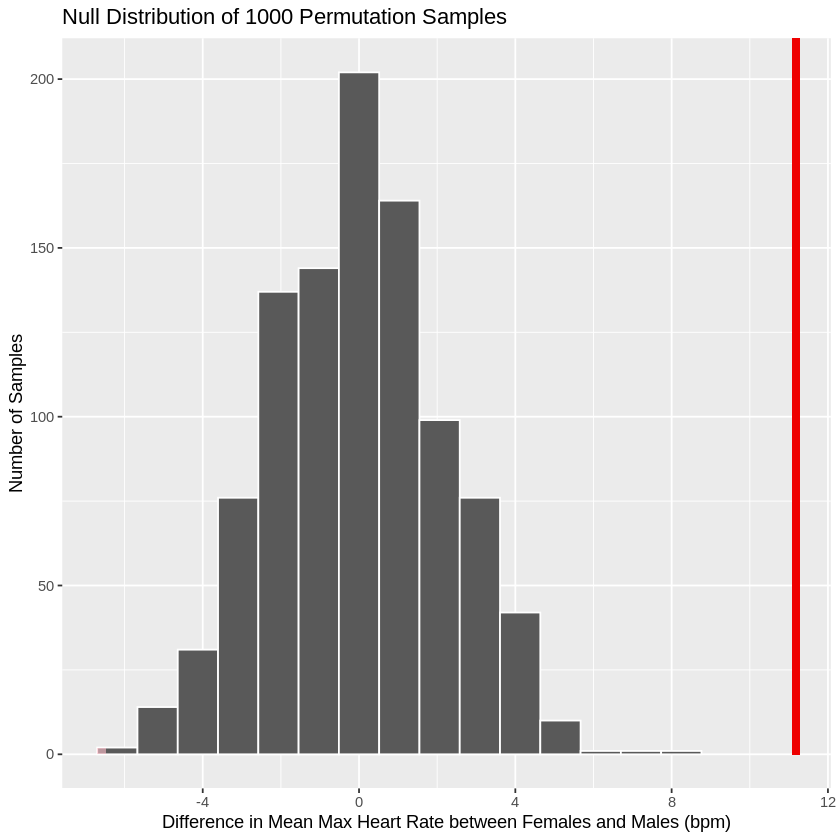

In [12]:
# see where our sample statistic lies on the null distribution
results_plot <- null_model %>%
    visualize() + 
    # our observed stat, or test statistic, is just our previously calculated sample point estimate
    shade_p_value(obs_stat = point_estimate, direction = "both") +
    labs(x = "Difference in Mean Max Heart Rate between Females and Males (bpm)",
         y = "Number of Samples", title = "Null Distribution of 1000 Permutation Samples")

results_plot

*plot 4*

It's quite far off! It seems like there's practically no chance at all for us to ever be able to get a sample with the same statistic as our sample point estimate if the null hypothesis is true. We can quantify this probability by calculating our p-value:

In [13]:
# our p_value
p_val <- null_model %>%
    get_p_value(obs_stat = point_estimate, direction = "both") %>%
    pull(p_value)

p_val

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


[1] 0

Uh-oh, we have calculated a p-value of $0$. We can't actually claim that our $p\text{-}value$ is $0$ though since that would be claiming that we have no chance of making a type I error. However, since we did 1000 permuted repetitions, we can claim that our $p\text{-}value$ is less than $\frac{1}{1000}$ (since less than 1 of our 1000 samples had that mean). Thus, we can say that our $p\text{-}value < \frac{1}{1000}$ or that our $p\text{-}value < 0.001$.

Therefore, at the $5\%$ significance level, we `reject` the null hypothesis, as our $p\text{-}value < 0.001 < 0.05$ (our significance level).

### Using Resampling to Calculate a Confidence Interval: `bootstrapping`

Again, we are looking to calculate the $95 \%$ confidence interval of the difference in the means of the maximum heart rate of females and males$-$this time using bootstrapping, another form of resampling.

In [14]:
set.seed(6)

# create 1000 bootstrap samples and calculate their sample statistics
bootstrap_samples <- data %>%
    rep_sample_n(nrow(data), reps = 1000, replace = TRUE) %>%
    group_by(replicate) %>%
    summarise(f_mean = mean(max_heart_rate[sex == "Female"]),
              m_mean = mean(max_heart_rate[sex == "Male"])) %>%
    group_by(replicate) %>%
    summarise(diff = f_mean - m_mean)

head(bootstrap_samples)

replicate,diff
<int>,<dbl>
1,12.634601
2,9.085475
3,13.640645
4,10.570741
5,14.233631
6,11.842065


*table 5*

Now that we have bootstrapped enough times, we can calculate our $95 \%$ confidence interval from the distribution of the bootstrap samples.

In [15]:
# get the 95% confidence interval using the bootstrap distribution formed from our samples
bootstrap_ci <- bootstrap_samples %>%
    get_ci(level = 0.95)
bootstrap_ci

lower_ci,upper_ci
<dbl>,<dbl>
7.474879,15.04523


*table 6*

Below is the visualization of the bootstrap distribution and its $95 \%$ confidence interval.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



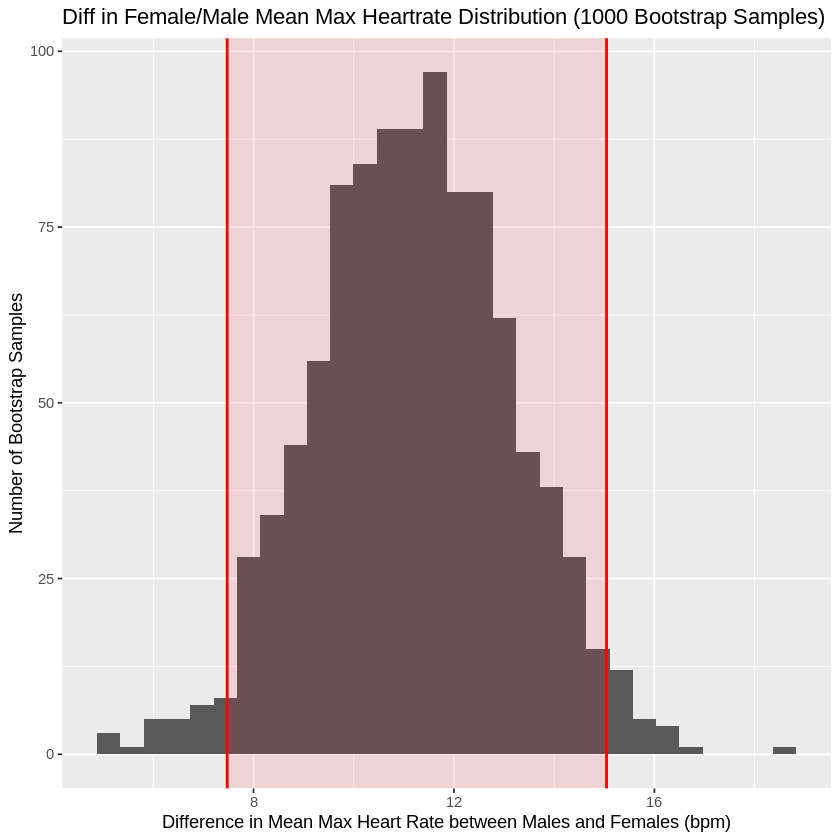

In [16]:
# visualise the bootstrap distribution and where the 95% confidence interval is

bootstrap_dist <- bootstrap_samples %>%
    ggplot(aes(x = diff)) +
    geom_histogram() +
    labs(x = "Difference in Mean Max Heart Rate between Males and Females (bpm)",
         y = "Number of Bootstrap Samples",
         title = "Diff in Female/Male Mean Max Heartrate Distribution (1000 Bootstrap Samples)") +
    geom_vline(data = bootstrap_ci, aes(xintercept = lower_ci), size = 0.8, color = 'red') +
    geom_vline(data = bootstrap_ci, aes(xintercept = upper_ci), size = 0.8, color = 'red') +
    annotate("rect",
             xmin = bootstrap_ci[[1]], xmax = bootstrap_ci[[2]],
             ymin = -Inf, ymax = Inf,
             fill = 'red',
             alpha = 0.1)

bootstrap_dist

*plot 5*

Based on the confidence interval above, we are $95 \%$ confident that the true difference means of maximum heart rate between different sexes will be between $7.47$ bpm and $15.05$ bpm. Since our bootstrapping is only as accurate to the population as our sample is, our confidence interval is again pretty wide. Since again we want $95 \%$ certainty, the trade-off for the bootstrap distribution is also more uncertainty.

## Discussion & Results
### Conclusion
From both methods, at a $5 \%$ significance level we `reject the null hypothesis`. Thus, we conclude that there is evidence to support a difference in the averages of the maximum heart rate achieved by females and males. In other words, to answer our inferential question, there is evidence to support maximum heart rate being dependent on sex.

Our sample indicates that the female mean maximum heart rate is higher than that of males. A report by Prabhavathi et. al. (2014) states that females have slightly smaller heart sizes than males. Being smaller and thus pumping less blood with each beat, the female heart would need to beat at a higher rate to match the blood circulation requirements in the body. This is one possible reason for a difference between the two means.

We must also take into account the drawbacks of our dataset that may skew our results. Our dataset is imbalanced in the number of observations of males and females$-$we have $673$ male observations and only $192$ female observations. Furthermore, our dataset is not fully representative of our population since it's only a sample. As it is, it only includes data from four regions, two in the U.S. and two in Europe. Our results could be biased due to that.

However, four regions spanning two continents are better than one, which makes our sample a better representation of the population than one drawn from a single hospital. And though our dataset is imbalanced in terms of observations per sex, our sample sizes are still large enough for us to use the asymptotic method of the t-test, where you are assuming large enough samples. Although our dataset is not perfectly representative of our population, it is far from being devoid of value.

### Were the Results Expected?
While computing our point estimate, we noticed that in our sample, the female mean maximum heart rate achieved was bigger than that of the male, so we expected to find a statistically significant difference in mean maximum heart rate achieved between the sexes (male ≠ female), rejecting our null hypothesis. As such, the results were expected.

### Method Comparison
The two methods are not all too different. Our sample size is $865$, quite large. So the `t-distribution` converges to the `normal distribution` due to the large degree of freedom (as it is partially dependent on sample size). Moreover, since we performed repeated resampling of our sample many times, the distributions created in those ways (`permutation`, `bootstrapping`) is also close to the `normal distribution`. Therefore, because the sample size is large enough, there will be no significant difference between the results of either method. And this is true because we ended up with similar results each time. Both tests produced a very low `p-value`, both resulting in a rejection of the null hypothesis. They also have similar confidence intervals.

However, the confidence interval of the `bootstrapping` method is wider than that of the `asymptotic` method. Although both methods have additional uncertainties due to accounting for sample variance, the confidence interval of the `asymptotic` method is narrower, which means that this method has higher precision. In addition, `bootstrapping` does not improve the quality of estimation since it's based on the quality of our sample. It only allows us to simulate a sampling distribution when we only have one sample. As well, the `asymptotic` method of hypothesis testing resulted in a non-zero p-value, which is more trustworthy than the `resampling` method, with its p-value of $0$.

Therefore, we think that the `asymptotic` method is a better choice than the `resampling` method.

### Future Considerations
We concluded that there's evidence of there being a difference between the average maximum heart rate achieved between the sexes. If we were to take this study further, we might consider whether the difference in average maximum heart rate would cause one sex to have better cardiac function, as well as survival in the face of cardiac disease, than the other. Furthermore, the data can be used to observe other factors that affect heart rate, such as age. Another possible question to be explored is whether heart rate depends more on age than sex. Specifically, does aging lead to the disappearance of heart rate differences between men and women? In addition, we could think back to the origins of this dataset and consider what heart disease could do to heart rate. For example, would there be notable differences in the heart rates of healthy people and people with heart problems? Is there a difference in heart rate between the sexes in people with heart disease, and would that be different from the heart rate difference between the sexes of healthy people?

# References

- Di Fusco, Stefania A., et al. "The Influence of Gender on Heart Rhythm Disease." Pacing and Clinical Electrophysiology, vol. 37, no. 5, 2014, pp. 650-657.

- Roth, Gregory A., et al. "Global Burden of Cardiovascular Diseases and Risk Factors, 1990-2019: Update from the GBD 2019 Study." Journal of the American College of Cardiology, vol. 76, no. 25, 2020, pp. 2982-3021.

- Tsao, Connie W., et al. "Heart Disease and Stroke Statistics-2022 Update: A Report from the American Heart Association." Circulation (New York, N.Y.), vol. 145, no. 8, 2022, pp. E153-e639.
 
- Prabhavathi, K., et al. “Role of Biological Sex in Normal Cardiac Function and in Its Disease Outcome - A Review.” Journal of Clinical and Diagnostic Research : JCDR, U.S. National Library of Medicine, Aug. 2014, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4190707/#:~:text=This%20difference%20is%20largely%20accounted,the%20larger%20male%20heart's%20output. 

- UCI Machine Learning Repository: Heart Disease Data Set, https://archive.ics.uci.edu/ml/datasets/Heart+Disease

- “Women and Heart Rate: What's Normal & What Impacts It.” Cleveland Clinic, https://my.clevelandclinic.org/health/articles/17644-women-and-heart-rate. 
